In [1]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.feature_selection import f_classif

In [2]:
import tcr_emb_code
import data_processing

In [2]:
!wget https://zenodo.org/record/6339774/files/pools.zip -P data/

--2023-07-14 15:31:35--  https://zenodo.org/record/6339774/files/pools.zip
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 518236823 (494M) [application/octet-stream]
Saving to: ‘data/pools.zip’

pools.zip           100%[===================>] 494.23M  3.29MB/s    in 3m 28s  

2023-07-14 15:35:04 (2.38 MB/s) - ‘data/pools.zip’ saved [518236823/518236823]



In [5]:
!unzip data/pools.zip

Archive:  data/pools.zip
   creating: pools/
  inflating: pools/mouse.tra.aa.txt  
  inflating: pools/compute_pwms.sh   
  inflating: pools/human.trb.aa.txt  
  inflating: pools/mir-1.0-SNAPSHOT.jar  
  inflating: pools/human.tra.aa.txt  
  inflating: pools/mouse.trb.aa.txt  
   creating: pools/pwms/
  inflating: pools/pwms/mouse.tra.aa.aa_cdr3_pwm.txt  
  inflating: pools/pwms/human.trb.aa.aa_cdr3_pwm.txt  
  inflating: pools/pwms/mouse.trb.aa.aa_cdr3_pwm.txt  
  inflating: pools/pwms/human.tra.aa.aa_cdr3_pwm.txt  


In [3]:
prototypes_path = 'data_scripts/prototypes_trb_aa.txt'

In [8]:
##prototypes = pd.read_csv('data/human.trb.aa.txt',sep='\t')

In [12]:
##prototypes = prototypes.sample(n=3000)
##prototypes.to_csv(prototypes_path,sep='\t', index = False)

In [4]:
data = pd.read_csv('/home/yuliajk/projects/tcr_embedding_r/vdjdb.slim.txt', sep='\t')
data = data[-data['reference.id'].str.startswith('https://www.10xgenomics')]
data = data[data['species']=='HomoSapiens']
data = data.rename(columns={'gene': 'chain'})
data

,chain,cdr3,species,antigen.epitope,antigen.gene,antigen.species,complex.id,v.segm,j.segm,v.end,j.start,mhc.a,mhc.b,mhc.class,reference.id,vdjdb.score
3,TRA,CASNTGTASKLTF,HomoSapiens,GILGFVFTL,M,InfluenzaA,0,TRAV24*01,TRAJ44*01,2,3,HLA-A*02,B2M,MHCI,PMID:28423320,0
6,TRA,CAVLLEYGNKLVF,HomoSapiens,GILGFVFTL,M,InfluenzaA,0,TRAV12-2*01,TRAJ47*01,3,5,HLA-A*02,B2M,MHCI,PMID:28423320,0
8,TRB,CASSAFPCREGRNNEQFF,HomoSapiens,NLVPMVATV,pp65,CMV,0,TRBV6-1*01,TRBJ2-1*01,4,13,HLA-A*02,B2M,MHCI,PMID:28423320,0
12,TRB,CASSLTTESGEQYF,HomoSapiens,NLVPMVATV,pp65,CMV,0,TRBV7-9*01,TRBJ2-7*01,5,10,HLA-A*02,B2M,MHCI,PMID:28423320,0
13,TRA,CLVGATTDSWGKLQF,HomoSapiens,NLVPMVATV,pp65,CMV,0,TRAV4*01,TRAJ24*01,4,-1,HLA-A*02,B2M,MHCI,PMID:28423320,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62682,TRA,CAVNSFFSDGQKLLF,HomoSapiens,NLVPMVATV,pp65,CMV,0,TRAV8-1*01,NaN,4,-1,HLA-A*02,B2M,MHCI,PMID:28423320,0
62683,TRB,CASSRRTSGGADEQFF,HomoSapiens,FRDYVDRFYKTLRAEQASQE,Gag,HIV-1,0,TRBV2*01,TRBJ2-1*01,4,12,HLA-DRA*01:01,HLA-DRB5*01:01,MHCII,PMID:27111229,0
62686,TRB,CASSSSRASKSYNEQFF,HomoSapiens,NLVPMVATV,pp65,CMV,0,TRBV7-9*01,TRBJ2-1*01,4,10,HLA-A*02,B2M,MHCI,PMID:28423320,0
62695,TRA,CALSEASGYSTLTF,HomoSapiens,NLVPMVATV,pp65,CMV,0,TRAV19*01,TRAJ11*01,5,6,HLA-A*02,B2M,MHCI,PMID:28423320,0


In [5]:

chain = 'TRB'
file_path_prefix = 'vdjdb_trb_aa'
file_date = '140723'

In [6]:
data = tcr_emb_code.filter_table_vdjdb(data,chain)
data = tcr_emb_code.data_filter_for_prototypes(data,prototypes_path,'v.segm','j.segm')
data_mir = tcr_emb_code.columns_prep_vdjdb(data)

In [7]:
tcr_emb_code.mir_clac(data_mir, file_path_prefix, file_date, chain, prototypes_path,False)

In [8]:
data_dists_raw_path = 'data_scripts/' + file_path_prefix + file_date + '.dist.txt'
data_dists_raw = pd.read_csv(data_dists_raw_path, sep = '\t')
data_c_b_dist = tcr_emb_code.mir_dists_format(data_dists_raw, data,'cdr3')
data_c_b_dist

,cdr3_1,cdr3_10,cdr3_100,cdr3_1000,cdr3_1001,cdr3_1002,cdr3_1003,cdr3_1004,cdr3_1005,cdr3_1006,...,j_990,j_991,j_992,j_993,j_994,j_995,j_996,j_997,j_998,j_999
cdr3,,,,,,,,,,,,,,,,,,,,,
CASSAFPCREGRNNEQFF,17.0,6.0,26.0,20.0,12.0,31.0,24.0,20.0,35.0,11.0,...,62.0,41.0,62.0,62.0,85.0,85.0,45.0,41.0,62.0,62.0
CASSLTTESGEQYF,24.0,14.0,32.0,15.0,15.0,36.0,22.0,34.0,27.0,10.0,...,81.0,43.0,81.0,81.0,62.0,62.0,46.0,43.0,81.0,81.0
CASSLGTLEETQYF,30.0,9.0,20.0,15.0,17.0,28.0,21.0,38.0,35.0,3.0,...,54.0,35.0,54.0,54.0,54.0,54.0,35.0,35.0,54.0,54.0
CASIPEGGRETQYF,37.0,10.0,15.0,18.0,17.0,32.0,17.0,28.0,39.0,-1.0,...,54.0,35.0,54.0,54.0,54.0,54.0,35.0,35.0,54.0,54.0
CASSLDSLNTIYF,16.0,22.0,16.0,11.0,20.0,21.0,12.0,27.0,30.0,8.0,...,35.0,33.0,35.0,35.0,35.0,35.0,33.0,33.0,35.0,35.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CASSRLAGGTGELFF,12.0,29.0,27.0,14.0,4.0,30.0,7.0,18.0,39.0,9.0,...,42.0,38.0,42.0,42.0,49.0,49.0,40.0,38.0,42.0,42.0
CASSLEAADNYGYTF,3.0,23.0,16.0,0.0,6.0,15.0,4.0,12.0,16.0,15.0,...,43.0,80.0,43.0,43.0,41.0,41.0,42.0,80.0,43.0,43.0
CASSRRTSGGADEQFF,24.0,23.0,25.0,19.0,11.0,32.0,17.0,27.0,29.0,7.0,...,62.0,41.0,62.0,62.0,85.0,85.0,45.0,41.0,62.0,62.0


In [9]:
pc_n = 3000
pca_df, pca_model = data_processing.pca(data_c_b_dist,pc_n)
pca_df_data = pca_df.copy()
pca_df_data['cdr3']=data_c_b_dist.index
pca_df_data['antigen.epitope']=data['antigen.epitope']
pca_df_data['j.segm']=data['j.segm']
pca_df_data['v.segm']=data['v.segm']
#pca_df_data=pca_df_data.merge(data[['cdr3','antigen.epitope','j.segm','v.segm']], on='cdr3')
#pca_df_data= pca_df_data.groupby(['cdr3']).first().reset_index()
pca_df_data['categorical_label'] = data_processing.cat_lable(pca_df_data['antigen.epitope'])
pca_df_data.shape


(15700, 3005)

/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or mis

Text(0, 0.5, '1 component')

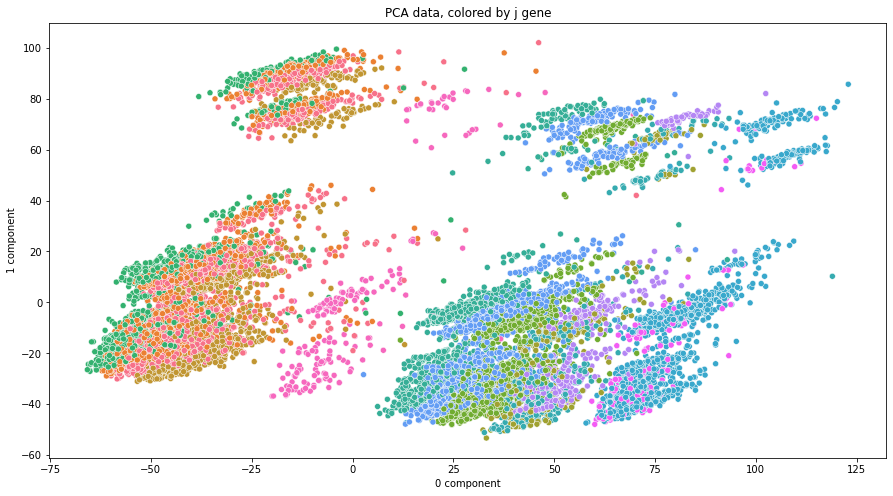

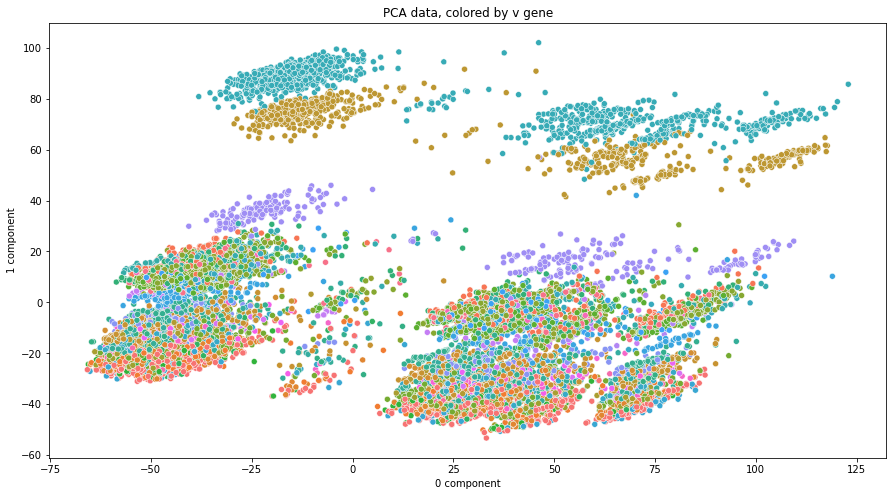

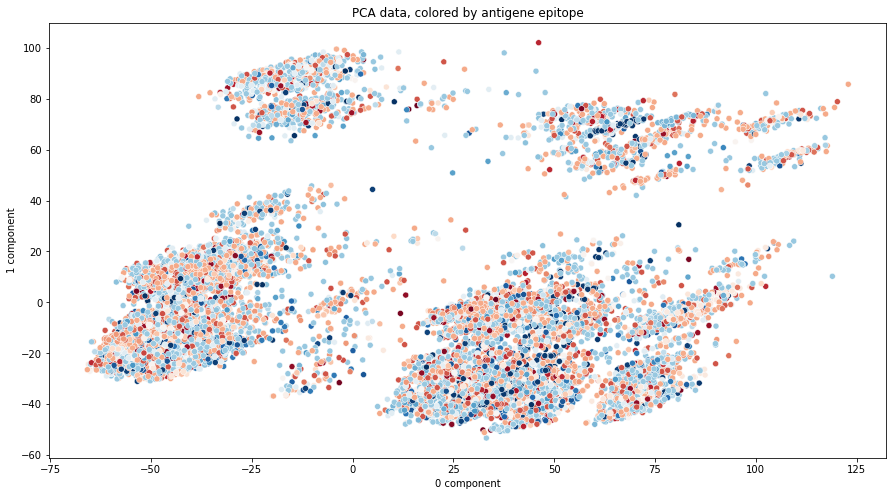

In [10]:
pc1 = 0
pc2 = 1
plt.figure(figsize=(15,8))
ax = sns.scatterplot(pc1, pc2, data=pca_df_data, hue='j.segm', legend = False)
ax.set_title("PCA data, colored by j gene")
ax.set_xlabel(str(pc1)+" component")
ax.set_ylabel(str(pc2)+" component")
plt.figure(figsize=(15,8))
ax = sns.scatterplot(pc1, pc2, data=pca_df_data, hue='v.segm',legend = False)
ax.set_title("PCA data, colored by v gene")
ax.set_xlabel(str(pc1)+" component")
ax.set_ylabel(str(pc2)+" component")
plt.figure(figsize=(15,8))
ax = sns.scatterplot(pc1, pc2, data=pca_df_data, hue='categorical_label',legend = False,palette='RdBu')
ax.set_title("PCA data, colored by antigene epitope")
ax.set_xlabel(str(pc1)+" component")
ax.set_ylabel(str(pc2)+" component")

In [11]:
pc_anova = data_processing.pc_anova(pca_df_data,pc_n, 'antigen.epitope')
pc_anova = pc_anova.sort_values('pvalue').reset_index(drop=True)
pc_selected = list(pc_anova['pc'].head(50))

In [12]:
pc_selected = list(pc_anova['pc'].head(50))

In [13]:
X_embedded = data_processing.tsne(pca_df[pc_selected],2,10,20)
tsne_df = pd.DataFrame(data = X_embedded, columns = ['DM1', 'DM2'])


tsne_df_data = tsne_df.copy()
tsne_df_data['cdr3']=data_c_b_dist.index
tsne_df_data['antigen.epitope'] = data['antigen.epitope']
tsne_df_data['j.segm'] = data['j.segm']
tsne_df_data['v.segm'] = data['v.segm']
#tsne_df_data=tsne_df_data.merge(data[['cdr3','antigen.epitope','j.segm','v.segm']], on='cdr3')
#tsne_df_data= tsne_df_data.groupby(['cdr3']).first().reset_index()
tsne_df_data['categorical_label'] = data_processing.cat_lable(tsne_df_data['antigen.epitope'])
tsne_df_data['cdr3_in_epitope_count'] = tsne_df_data.groupby('antigen.epitope')['cdr3'].transform("size")
tsne_df_data['epitope_type'] = tsne_df_data['cdr3_in_epitope_count'].apply(lambda x: 'other' if x < 300 else 'class') 

tsne_df_data

,DM1,DM2,cdr3,antigen.epitope,j.segm,v.segm,categorical_label,cdr3_in_epitope_count,epitope_type
0,-38.492790,28.487850,CASSAFPCREGRNNEQFF,NLVPMVATV,TRBJ2-1,TRBV6-1,112,4171,class
1,-73.815804,-62.155624,CASSLTTESGEQYF,NLVPMVATV,TRBJ2-7,TRBV7-9,112,4171,class
2,-1.091793,15.691837,CASSLGTLEETQYF,NLVPMVATV,TRBJ2-5,TRBV6-5,112,4171,class
3,-11.567662,-59.367302,CASIPEGGRETQYF,GLCTLVAML,TRBJ2-5,TRBV7-8,51,858,class
4,47.954380,-73.647644,CASSLDSLNTIYF,NLVPMVATV,TRBJ1-3,TRBV5-1,112,4171,class
...,...,...,...,...,...,...,...,...,...
15695,32.355793,-97.651978,CASSRLAGGTGELFF,QIKVRVKMV,TRBJ2-2,TRBV7-3,121,23,other
15696,81.168449,-40.123310,CASSLEAADNYGYTF,GLCTLVAML,TRBJ1-2,TRBV5-5,51,858,class
15697,-36.282021,-10.757387,CASSRRTSGGADEQFF,FRDYVDRFYKTLRAEQASQE,TRBJ2-1,TRBV2,46,390,class
15698,-41.094749,-77.857239,CASSSSRASKSYNEQFF,NLVPMVATV,TRBJ2-1,TRBV7-9,112,4171,class


/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or mis

Text(0.5, 1.0, 'TSNE of VDJdb data after PCA, colored by antigen.epitope')

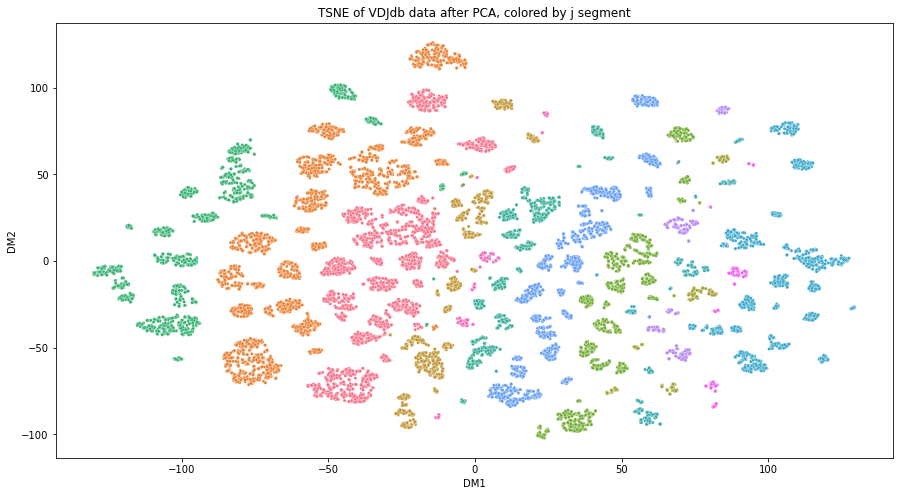

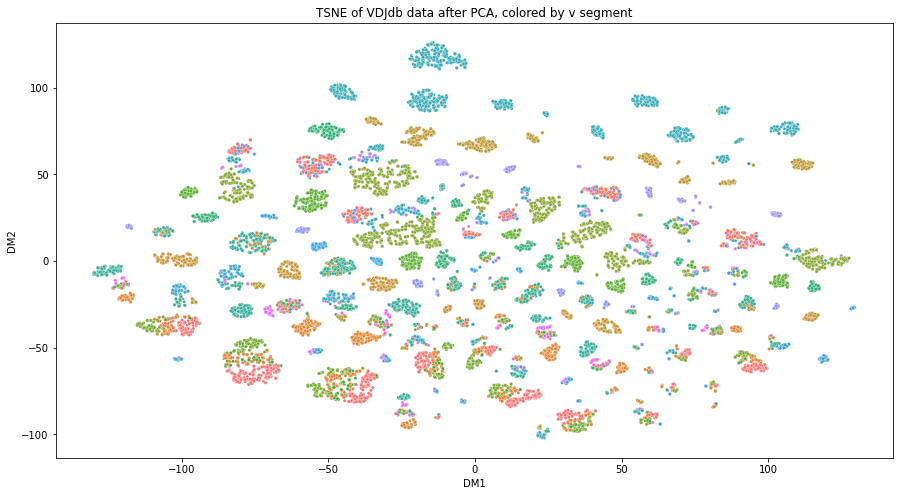

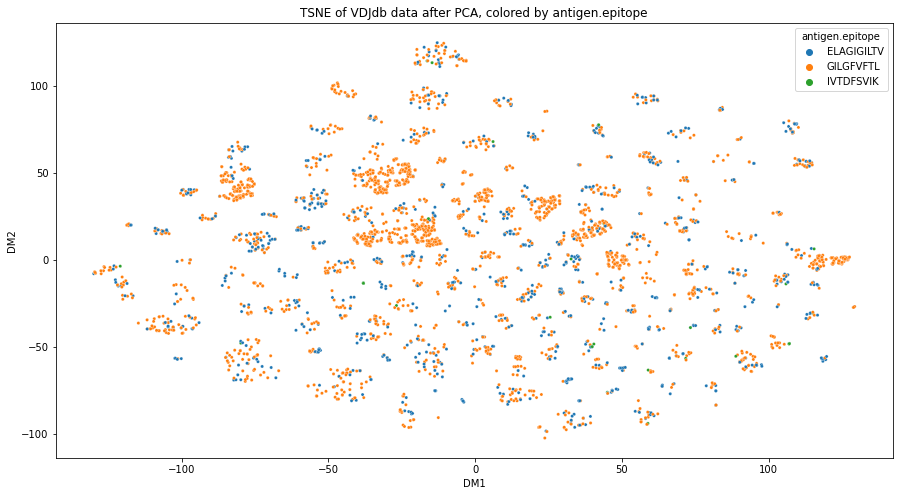

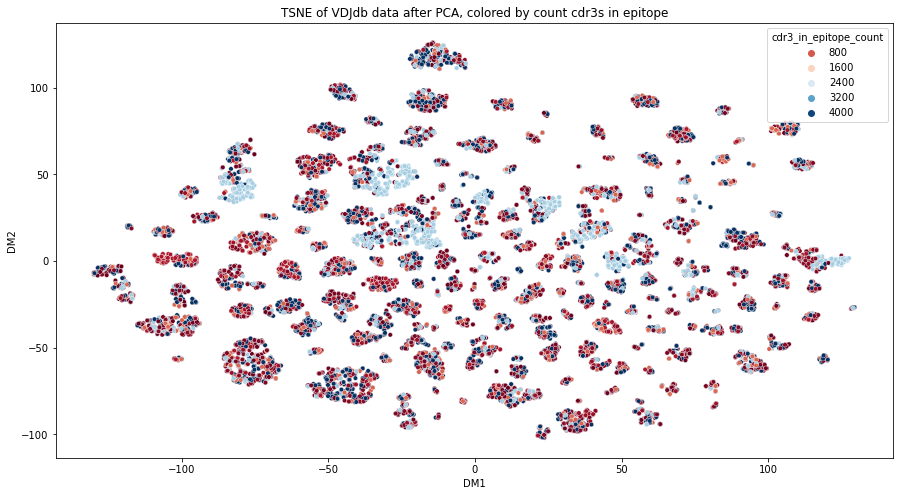

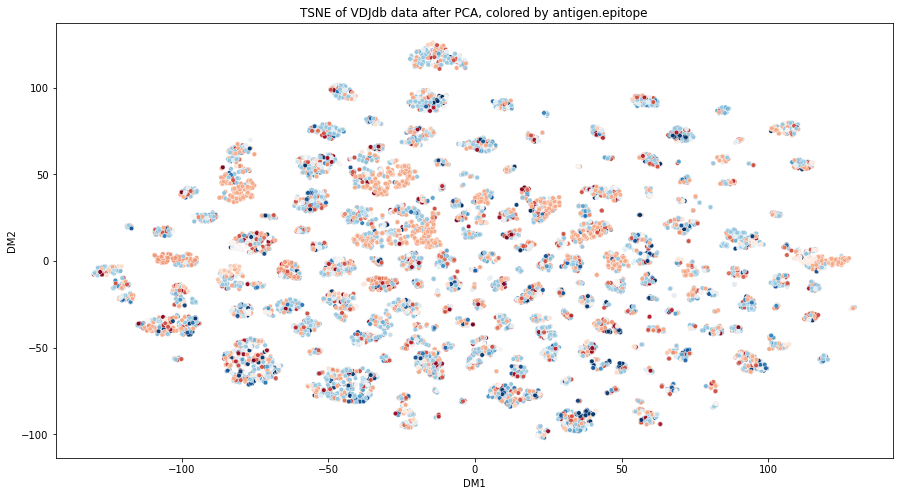

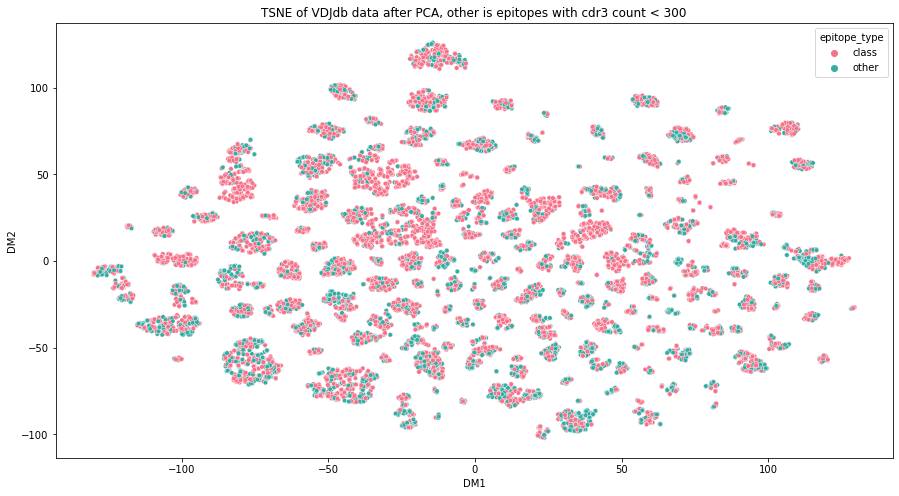

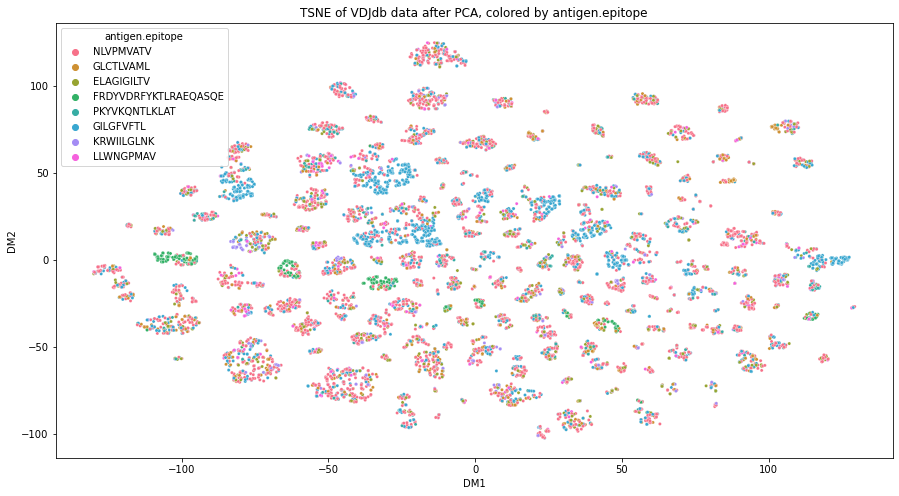

In [14]:
plt.figure(figsize=(15,8))
ax = sns.scatterplot('DM1', 'DM2', data=tsne_df_data, hue='j.segm',s=10,legend = False)
ax.set_title("TSNE of VDJdb data after PCA, colored by j segment")

plt.figure(figsize=(15,8))
ax = sns.scatterplot('DM1', 'DM2', data=tsne_df_data, hue='v.segm',s=10,legend = False)
ax.set_title("TSNE of VDJdb data after PCA, colored by v segment")

plt.figure(figsize=(15,8))
ax = sns.scatterplot('DM1', 'DM2', data=tsne_df_data[tsne_df_data['antigen.epitope'].isin(['KLGGALQAK','AAKGRGAAL','GILGFVFTL','ELAGIGILTV','RLRAEAQVK','IVTDFSVIK'])], hue='antigen.epitope',s=10)
ax.set_title("TSNE of VDJdb data after PCA, colored by antigen.epitope")

plt.figure(figsize=(15,8))
sns.set_palette("husl")
ax = sns.scatterplot('DM1', 'DM2', data=tsne_df_data, hue='cdr3_in_epitope_count',s=20,palette='RdBu')
ax.set_title("TSNE of VDJdb data after PCA, colored by count cdr3s in epitope")

plt.figure(figsize=(15,8))
sns.set_palette("husl")
ax = sns.scatterplot('DM1', 'DM2', data=tsne_df_data, hue='categorical_label',s=20,legend = False,palette='RdBu')
ax.set_title("TSNE of VDJdb data after PCA, colored by antigen.epitope")

plt.figure(figsize=(15,8))
ax = sns.scatterplot('DM1', 'DM2', data=tsne_df_data, hue= 'epitope_type' ,s=20,palette = 'husl')
ax.set_title("TSNE of VDJdb data after PCA, other is epitopes with cdr3 count < 300")

plt.figure(figsize=(15,8))
ax = sns.scatterplot('DM1', 'DM2', data=tsne_df_data[tsne_df_data['epitope_type']=='class'], hue='antigen.epitope',s=10)
ax.set_title("TSNE of VDJdb data after PCA, colored by antigen.epitope")


In [15]:
tsne_df_data[tsne_df_data['epitope_type']=='other'].drop_duplicates('antigen.epitope')['antigen.epitope']


8             YSEHPTFTSQY
11             KLSALGINAV
12              IPSINVHHY
13       QARQMVQAMRTIGTHP
14            KAFSPEVIPMF
               ...       
14143       LPEPLPQGQGTAY
15190           VMAPRTLIL
15356           LLFGYPVAV
15529          ALWGPDPAAA
15650           EEYLQAFTY
Name: antigen.epitope, Length: 155, dtype: object

In [16]:
tsne_df_data[tsne_df_data['epitope_type']=='class'].drop_duplicates('antigen.epitope')['antigen.epitope']


0                NLVPMVATV
3                GLCTLVAML
5               ELAGIGILTV
6     FRDYVDRFYKTLRAEQASQE
17           PKYVKQNTLKLAT
19               GILGFVFTL
62              KRWIILGLNK
67               LLWNGPMAV
Name: antigen.epitope, dtype: object

In [17]:
kmeans = KMeans(n_clusters=100, random_state=0).fit(pca_df)

In [18]:
clusters = pd.DataFrame(kmeans.labels_, columns= ['cluster'])
df_kmeans = pd.concat([tsne_df_data, clusters], axis = 1)

/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


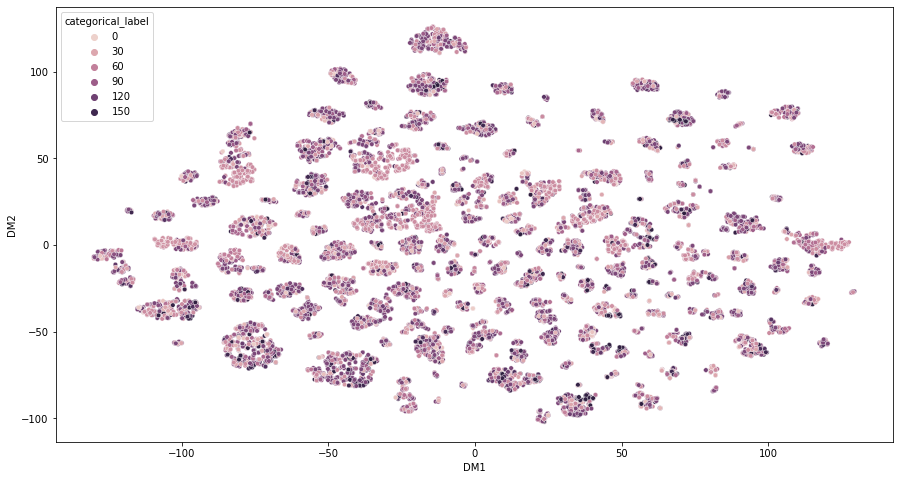

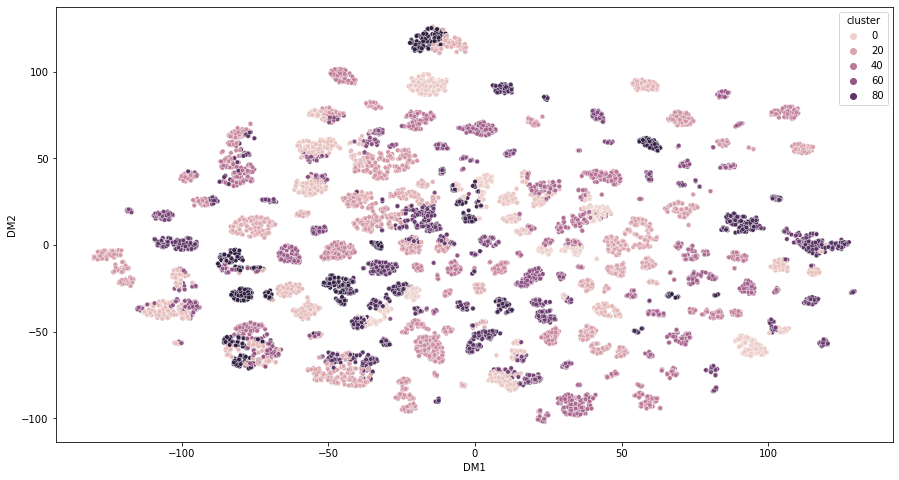

In [19]:
plt.figure(figsize=(15,8))
ax = sns.scatterplot('DM1', 'DM2', data=df_kmeans, hue='categorical_label',s=20)
#ax = sns.scatterplot('DM1', 'DM2', data=tsne_df,s=10)
#ax.text(x=0.5, y=1.1, s='TSNE of VDJdb 10x data after PCA, colored by cell.subset', fontsize=12, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
#ax.text(x=0.5, y=1.05, s='TCRemb', fontsize=10, alpha=0.75, ha='center', va='bottom', transform=ax.transAxes)
#ax.set_title("TSNE of VDJdb 10x data after PCA, colored by j segment")
plt.figure(figsize=(15,8))
ax = sns.scatterplot('DM1', 'DM2', data=df_kmeans, hue='cluster',s=20)

In [22]:
from scipy import stats

In [23]:
#binominal test
binom_df = df_kmeans.copy()
binom_df['total_cluster'] = binom_df.groupby('cluster')['cluster'].transform('count')
binom_df['total_epi'] = binom_df.groupby('antigen.epitope')['antigen.epitope'].transform('count')
binom_df['count_mached'] = binom_df.groupby(['antigen.epitope','cluster'])['antigen.epitope'].transform('count')
binom_df['fraction_matched'] = binom_df['count_mached']/binom_df['total_cluster']
binom_df['fraction_matched_exp'] = binom_df['total_epi']/len(binom_df.index)
binom_df['p_value'] = binom_df.apply(lambda row: stats.binom_test(row['count_mached'], n=row['total_cluster'], p=row['fraction_matched_exp'], alternative='greater'),axis=1)
binom_df = binom_df[binom_df['fraction_matched']>binom_df['fraction_matched_exp']]
binom_df_v = binom_df[['antigen.epitope','cluster','total_cluster','total_epi','count_mached','fraction_matched','fraction_matched_exp','p_value']].drop_duplicates().sort_values('p_value')
#binom_df_v.to_csv('data_scripts/emb_binom_df.txt',sep='\t', index = False)
binom_df_cluster = binom_df_v.copy()
binom_df_cluster = binom_df_cluster.sort_values(['fraction_matched'],ascending=False)
binom_df_cluster = binom_df_cluster.drop_duplicates('cluster',keep='first')
binom_df_cluster

,antigen.epitope,cluster,total_cluster,total_epi,count_mached,fraction_matched,fraction_matched_exp,p_value
207,GILGFVFTL,43,179,2795,158,0.882682,0.178025,7.450866e-94
60,FRDYVDRFYKTLRAEQASQE,79,158,390,118,0.746835,0.024841,7.618127e-153
19,GILGFVFTL,26,355,2795,244,0.687324,0.178025,1.406384e-98
57,GILGFVFTL,77,296,2795,199,0.672297,0.178025,4.388885e-78
81,FRDYVDRFYKTLRAEQASQE,78,140,390,89,0.635714,0.024841,2.185833e-105
...,...,...,...,...,...,...,...,...
153,GLCTLVAML,12,138,858,11,0.079710,0.054650,1.352962e-01
354,EIYKRWII,28,164,148,13,0.079268,0.009427,7.566473e-09
2571,DPFRLLQNSQVFS,72,76,100,6,0.078947,0.006369,9.966360e-06
859,GLCTLVAML,5,224,858,17,0.075893,0.054650,1.087236e-01


In [24]:
binom_df_cluster.head(10)

,antigen.epitope,cluster,total_cluster,total_epi,count_mached,fraction_matched,fraction_matched_exp,p_value
207,GILGFVFTL,43,179,2795,158,0.882682,0.178025,7.450866e-94
60,FRDYVDRFYKTLRAEQASQE,79,158,390,118,0.746835,0.024841,7.618127e-153
19,GILGFVFTL,26,355,2795,244,0.687324,0.178025,1.406384e-98
57,GILGFVFTL,77,296,2795,199,0.672297,0.178025,4.388885e-78
81,FRDYVDRFYKTLRAEQASQE,78,140,390,89,0.635714,0.024841,2.185833e-105
21,GILGFVFTL,83,195,2795,111,0.569231,0.178025,2.372820e-34
143,NLVPMVATV,88,173,4171,94,0.543353,0.265669,1.062844e-14
533,GILGFVFTL,48,207,2795,108,0.521739,0.178025,4.894877e-29
107,FRDYVDRFYKTLRAEQASQE,55,135,390,65,0.481481,0.024841,2.333395e-66
159,GLCTLVAML,56,70,858,33,0.471429,0.054650,2.926979e-23


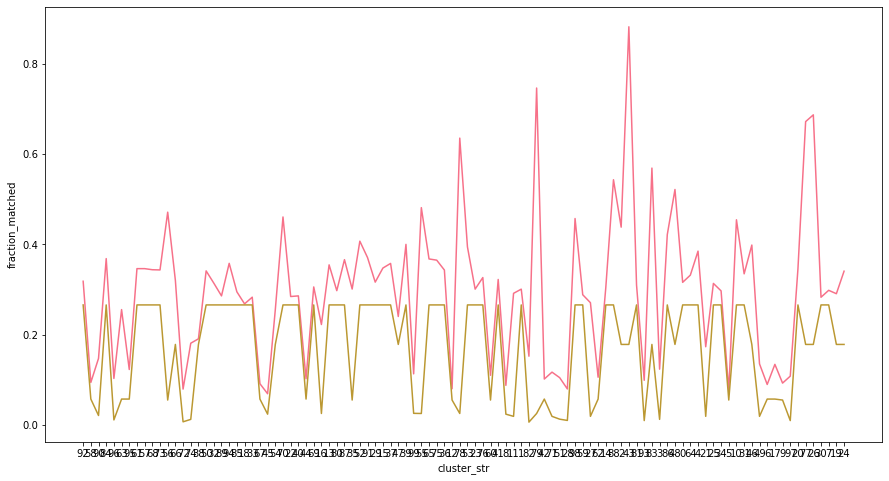

In [26]:
plt.figure(figsize=(15,8))
ax = sns.lineplot(x='cluster_str', y='fraction_matched', data=binom_df_cluster.sort_values('total_cluster'))
ax = sns.lineplot(x='cluster_str', y='fraction_matched_exp', data=binom_df_cluster.sort_values('total_cluster'))

In [27]:
ordered_df = binom_df_cluster.sort_values(by='total_cluster')


In [28]:
ordered_df = binom_df_cluster.sort_values(by='total_cluster')
ordered_df['cluster_str'] = ordered_df['cluster'].astype('string')

Text(0, 0.5, 'Clusters')

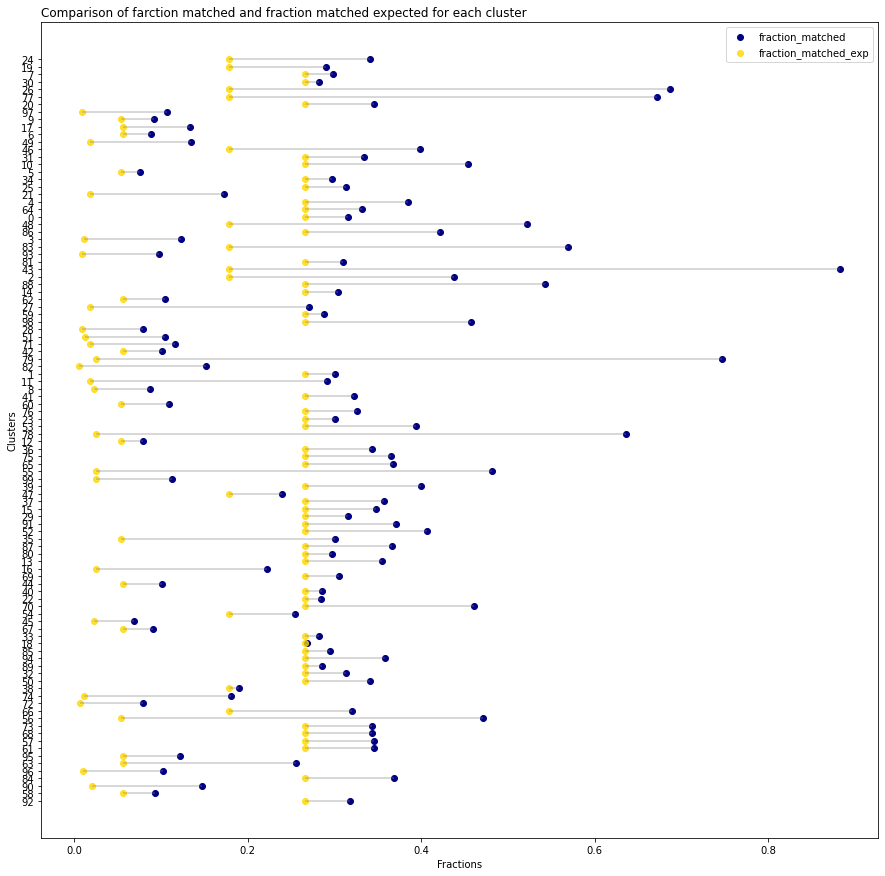

In [29]:
plt.figure(figsize=(15,15))
plt.hlines(y=ordered_df['cluster_str'], xmin=ordered_df['fraction_matched_exp'], xmax=ordered_df['fraction_matched'], color='grey', alpha=0.4)
plt.scatter(ordered_df['fraction_matched'], ordered_df['cluster_str'], color='navy', alpha=1, label='fraction_matched')
plt.scatter(ordered_df['fraction_matched_exp'], ordered_df['cluster_str'], color='gold', alpha=0.8 , label='fraction_matched_exp')
plt.legend()

# Add title and axis names
plt.title("Comparison of farction matched and fraction matched expected for each cluster", loc='left')
plt.xlabel('Fractions')
plt.ylabel('Clusters')

In [82]:
tsne_df_data_filtered = tsne_df_data[tsne_df_data['epitope_type']=='class']

In [ ]:
kmeans = KMeans(n_clusters=30, random_state=0).fit(pca_df)
clusters = pd.DataFrame(kmeans.labels_, columns= ['cluster'])
df_kmeans = pd.concat([tsne_df_data, clusters], axis = 1)
df_kmeans